In [135]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [136]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Using device: {device}')
    print(f'GPU: {torch.cuda.get_device_name(0)}')
else:
    print(f'Using device: {device}')

Using device: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER


In [137]:
# Load data
df = pd.read_csv("BMED_DB_augmented.csv")
#df = df[df['exp'].isin([0,1,2,3,4])].reset_index(drop=True)

In [138]:
# Robust min-max scaling including safety margin
ranges ={
'V' : {'min':0, 'max':50},
'E' : {'min':0, 'max':1},
'VF' : {'min':0, 'max':2},
'VA' : {'min':0, 'max':2},
'VB' : {'min':0, 'max':8},
'CF_LA' : {'min':-1, 'max':4},
'CA_LA' : {'min':-1, 'max':4},
'CF_K' : {'min':-1, 'max':7},
'CB_K' : {'min':-1, 'max':2},
}

In [139]:
# Data normalization
ndf = pd.DataFrame()
ndf['exp'] = df['exp']; ndf['t'] = df['t']

for col in ['V', 'E', 'VF', 'VA', 'VB', 'CF_LA', 'CA_LA', 'CF_K', 'CB_K']:
    if col in ranges:
        ndf[col] = (df[col] - ranges[col]['min'])/(ranges[col]['max'] - ranges[col]['min'])
    else:
        ndf[col] = df[col]

In [140]:
# prepare data
def prepare_data(ndf):
    '''
    prepare data list for each experiment

    Args:
        ndf: normalized dataframe
    
    Returns:
        Vt_list: list of applied voltage
        E_list: list of external electrolyte concentration
        CFLA_list: list of feed LA concentration
        CALA_list: list of acid LA concentration
        CFK_list: list of feed K concentration
        CBK_list: list of base K concentration
        VF_list: list of feed volume
        VA_list: list of acid volume
        VB_list: list of base volume
    '''
    Vt_list, E_list, CFLA_list, CALA_list, CFK_list, CBK_list, VF_list, VA_list, VB_list = [], [], [], [], [], [], [], [], []

    for exp_num in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp_num]

        # operating conditions
        Vt_list.append(exp_data['V'].values)
        E_list.append(exp_data['E'].values)

        # concentrations
        CFLA_list.append(exp_data['CF_LA'].values)
        CALA_list.append(exp_data['CA_LA'].values)
        CFK_list.append(exp_data['CF_K'].values)
        CBK_list.append(exp_data['CB_K'].values)

        # volumes
        VF_list.append(exp_data['VF'].values)
        VA_list.append(exp_data['VA'].values)
        VB_list.append(exp_data['VB'].values)


    return Vt_list, E_list, CFLA_list, CALA_list, CFK_list, CBK_list, VF_list, VA_list, VB_list

Vt_list, E_list, CFLA_list, CALA_list, CFK_list, CBK_list, VF_list, VA_list, VB_list = prepare_data(ndf)

In [141]:
# Pad sequences
def pad_sequences(data_list, max_length=None, pad_value=-100.0):
    '''
    Pad variables length sequences to the same length

    Args:
        data_list: list of tensors with different sequence lengths
        max_length: maximum length to pad to (default: longest sequence)
        pad_value: value to use for padding

    Returns:
        padded_tensor: [batch_size, max_length, ...] - padded sequences
        seq_lengths: [batch_size] - original sequence lengths
    '''

    if max_length is None:
        max_length = max(data.shape[0] for data in data_list) # Auto-calculate the max length
    
    batch_size = len(data_list) # Batch size
    seq_lengths = torch.tensor([data.shape[0] for data in data_list]) # Actual sequential length for each experiments
    dimensions = data_list[0].shape[1:] # Get shape of individual elements
    padded_tensor = torch.full((batch_size, max_length) + dimensions, pad_value, dtype=torch.float32) # generaste padded tensor filled with pad_value

    # Fill with actual data
    for i, data in enumerate(data_list):
        padded_tensor[i, :data.shape[0]] = torch.tensor(data[:data.shape[0]], dtype=torch.float32)
    
    return padded_tensor, seq_lengths, max_length

Vt, seq_lengths, max_length = pad_sequences(Vt_list)
E, _, _ = pad_sequences(E_list,max_length = max_length)
CFLA, _, _ = pad_sequences(CFLA_list,max_length = max_length)
CALA, _, _ = pad_sequences(CALA_list,max_length = max_length)
CFK, _, _ = pad_sequences(CFK_list,max_length = max_length)
CBK, _, _ = pad_sequences(CBK_list,max_length = max_length)
VF, _, _ = pad_sequences(VF_list,max_length = max_length)
VA, _, _ = pad_sequences(VA_list,max_length = max_length)
VB, _, _ = pad_sequences(VB_list,max_length = max_length)

In [142]:
# Prepare input tensor
def prepare_input(Vt, E, CFLA, CALA, CFK, CBK, VF, VA, VB, seq_lengths):
    '''
    prepare input tensor for the model with padding support

    Args:
        Vt: applied voltage
        E: external electrolyte concentration
        CFLA: feed LA concentration
        CALA: acid LA concentration
        CFK: feed K concentration
        CBK: base K concentration
        VF: feed volume
        VA: acid volume
        VB: base volume
        seq_lengths: actual sequence lengths

    Returns:
        input_tensor: [batch_size, seq_len, 3, 6] - formatted input for CNN-LSTM
        initial_state: [batch_size, 3, 3] - initial concentrations and volumes
        mask: [batch_size, seq_len] - padding mask
        seq_lengths: [batch_size] - actual sequence lengths
    '''

    batch_size, seq_len = Vt.shape # Get batch size and sequence length for set the size of input tensor
    input = torch.zeros(batch_size, seq_len, 9) # Generate input tensor

    # Fill input tensor for each channel
    input[:, :, 0] = Vt # Applied voltage
    input[:, :, 1] = E # External electrolyte concentration
    input[:, :, 2] = CFLA # Feed LA concentration
    input[:, :, 3] = CALA # Acid LA concentration
    input[:, :, 4] = CFK # Feed K concentration
    input[:, :, 5] = CBK # Base K concentration
    input[:, :, 6] = VF # Feed volume
    input[:, :, 7] = VA # Acid volume
    input[:, :, 8] = VB # Base volume

    # initial state for each feature
    init = torch.zeros(batch_size, 9)
    init[:, 0] = Vt[:, 0] # Initial applied voltage
    init[:, 1] = E[:, 0] # Initial external electrolyte concentration
    init[:, 2] = CFLA[:, 0] # Initial feed LA concentration
    init[:, 3] = CALA[:, 0] # Initial acid LA concentration
    init[:, 4] = CFK[:, 0] # Initial feed K concentration
    init[:, 5] = CBK[:, 0] # Initial base K concentration
    init[:, 6] = VF[:, 0] # Initial feed volume
    init[:, 7] = VA[:, 0] # Initial acid volume
    init[:, 8] = VB[:, 0] # Initial base volume

    # Create padding mask
    mask = torch.zeros(batch_size, seq_len)
    for i, length in enumerate(seq_lengths):
        mask[i, :length] = 1.0

    return input, init, mask, seq_lengths

input_tensor, init, mask, seq_lengths = prepare_input(Vt, E, CFLA, CALA, CFK, CBK, VF, VA, VB, seq_lengths)

In [143]:
# Generate Dataset by experiments
class BMEDDataset(Dataset):
    def __init__(self, inputs, init, masks, seq_lengths, CFLA_exp, CALA_exp, CFK_exp, CBK_exp, VF_exp, VA_exp, VB_exp):
        self.CV = inputs[:, :, :2] # Extract [Vt, E]
        self.init = init[:, 2:] # Extract state variables
        self.masks = masks
        self.seq_lengths = seq_lengths

        self.states = torch.stack([CFLA_exp, CALA_exp, CFK_exp, CBK_exp, VF_exp, VA_exp, VB_exp], dim=2)

    def __len__(self):
        return len(self.CV)
    
    def __getitem__(self, idx):
        return {
            'CV': self.CV[idx],
            'init': self.init[idx],
            'masks': self.masks[idx],
            'seq_len': self.seq_lengths[idx],
            'states': self.states[idx],
        }
train_dataset = BMEDDataset(input_tensor, init, mask, seq_lengths, CFLA, CALA, CFK, CBK, VF, VA, VB)

In [144]:
# Generate DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [145]:
# Model Initialization
class BMEDModel(nn.Module):
    def __init__(self, hidden_nodes = 64, num_rnn_layers = 2, num_fnn_layers = 2,max_len = 37, dt = 0.25):
        super(BMEDModel, self).__init__()

        self.max_len = max_len
        self.input_features = 9 # [Vt, E, CFLA, CALA, CFK, CBK, VF, VA, VB]
        self.control_features = 2 # [Vt, E]
        self.state_features = 7 # [CFLA, CALA, CFK, CBK, VF, VA, VB]
        self.flux_features = 4 # [dLA, dK, dH2O_A, dH2O_B]
        self.dt = dt # time step
        self.hidden_nodes = hidden_nodes
        self.num_rnn_layers = num_rnn_layers
        self.ranges = {
            'CFLA': {'min': -1, 'max': 4},
            'CALA': {'min': -1, 'max': 4}, 
            'CFK': {'min': -1, 'max': 7},
            'CBK': {'min': -1, 'max': 2},
            'VF': {'min': 0, 'max': 2},
            'VA': {'min': 0, 'max': 2},
            'VB': {'min': 0, 'max': 8}
        }


        # Layer Normalization
        self.layer_norm = nn.LayerNorm(self.input_features)

        # RNN layers
        self.rnn_layers = nn.LSTM(
            input_size = self.input_features,
            hidden_size = hidden_nodes,
            num_layers = num_rnn_layers,
            batch_first = True,
            dropout = 0.2 if num_rnn_layers > 1 else 0
        )

        # Flux Head
        flux_layers = []
        flux_sizes = [hidden_nodes]
        flux_step = (hidden_nodes - self.flux_features) / (num_fnn_layers)
        
        for i in range(num_fnn_layers):
            next_size = int(hidden_nodes - flux_step * (i + 1))
            if i == num_fnn_layers - 1:
                next_size = self.flux_features
            
            flux_layers.append(nn.Linear(flux_sizes[-1], next_size))
            flux_layers.append(nn.ELU())
            flux_layers.append(nn.Dropout(0.2))
            flux_sizes.append(next_size)
            
        self.flux_NN = nn.Sequential(*flux_layers)
    
    
    def init_hidden(self, batch_size, device):
        """
        Initialize hidden states for RNN layers
        """
        h0 = torch.zeros(self.num_rnn_layers, batch_size, self.hidden_nodes, device=device)
        c0 = torch.zeros(self.num_rnn_layers, batch_size, self.hidden_nodes, device=device)
        return (h0, c0)
    
    def denormalize_state(self, norm_state):
        '''
        Normalized state to real values 
        '''
        batch_size = norm_state.shape[0]
        real_state = torch.zeros_like(norm_state)

        state_names = ['CFLA', 'CALA', 'CFK', 'CBK', 'VF', 'VA', 'VB']

        for i, name in enumerate(state_names):
            min_val = self.ranges[name]['min']
            max_val = self.ranges[name]['max']
            real_state[:, i] = norm_state[:, i] * (max_val - min_val) + min_val
        
        return real_state
    
    def normalize_state(self, real_state):
        '''
        Real state to normalized values
        '''
        batch_size = real_state.shape[0]
        norm_state = torch.zeros_like(real_state)

        state_names = ['CFLA', 'CALA', 'CFK', 'CBK', 'VF', 'VA', 'VB']

        for i, name in enumerate(state_names):
            min_val = self.ranges[name]['min']
            max_val = self.ranges[name]['max']
            norm_state[:, i] = (real_state[:, i] - min_val) / (max_val - min_val)

        return norm_state

    def MB_step(self, norm_state, LA_flux, K_flux, VFA_flux, VFB_flux):
        '''
        Perform one time step of mass balance
        state: [batch, 7] - [CFLA, CALA, CFK, CBK, VF, VA, VB]
        '''
        real_state = self.denormalize_state(norm_state)

        # extract current values
        # channel 0: feed, channel 1: acid, channel 2: base
        # property 0: LA_conc, property 1: K_conc, property 2: volume

        CFLA = real_state[:, 0]
        CALA = real_state[:, 1]
        CFK = real_state[:, 2]
        CBK = real_state[:, 3]
        VF = real_state[:, 4]
        VA = real_state[:, 5]
        VB = real_state[:, 6]

        # volume changes due to water flux
        # Assuming positive flux means water moves from feed to acid or base
        nVF = VF - (VFA_flux + VFB_flux) * self.dt # Feed Volume
        nVA = VA + VFA_flux * self.dt # Acid Volume
        nVB = VB + VFB_flux * self.dt # Base Volume

        # LA mass balance
        nNFLA = CFLA*VF - LA_flux*self.dt
        nNALA = CALA*VA + LA_flux*self.dt
        nNFK = CFK*VF - K_flux*self.dt
        nNBK = CBK*VB + K_flux*self.dt

        # update states
        new_real_state = torch.zeros_like(real_state)
        new_real_state[:, 0] = nNFLA / (nVF + 1e-8) # new Feed LA concentration
        new_real_state[:, 1] = nNALA / (nVA + 1e-8) # new Acid LA concentration
        new_real_state[:, 2] = nNFK / (nVF + 1e-8) # new Feed K concentration
        new_real_state[:, 3] = nNBK / (nVB + 1e-8) # new Base K concentration
        new_real_state[:, 4] = nVF # new Feed Volume
        new_real_state[:, 5] = nVA # new Acid Volume
        new_real_state[:, 6] = nVB # new Base Volume

        new_norm_state = self.normalize_state(new_real_state)
    
        return new_norm_state
    
    def forward_single_step(self, CV, prev_state, hidden_state):
        '''
        Predict Single Step of BMED
        CV: [batch_size, 2] - [Vt, E]
        prev_state: [batch_size, 7] - [CFLA, CALA, CFK, CBK, VF, VA, VB]
        hidden_state: [h, c] - hidden state of RNN layers
        '''

        full_input = torch.cat([CV, prev_state], dim=1)
        full_input = full_input.unsqueeze(1) # [batch_size, 1, 9]

        # Layer Normalization
        rnn_input = self.layer_norm(full_input)
        
        # RNN forward - pack all information of previous hidden state
        rnn_out, new_hidden_state = self.rnn_layers(rnn_input, hidden_state)

        # Predict flux and current
        flux = self.flux_NN(rnn_out.squeeze(1)) # [batch_size, 4]

        # Physical update
        LA_flux = flux[:, 0]
        K_flux = flux[:, 1]
        VFA_flux = flux[:, 2]
        VFB_flux = flux[:, 3]

        new_state = self.MB_step(prev_state, LA_flux, K_flux, VFA_flux, VFB_flux)

        return new_state, new_hidden_state
    
    def next_seq_pred_train(self, CV, init, states, masks):
        '''
        Autoregressive training
        '''
        batch_size, max_seq_len, _ = CV.shape
        device= CV.device

        mask = masks # [batch_size, max_seq_len]

        CVf = CV[:, 0, :] # [batch_size, 2]

        # Initialize hidden state
        hidden_state = self.init_hidden(batch_size,device)
        current_state = init.clone() # [batch_size, 7]

        # predicted results
        predicted_states = []

        # use init_state at t=0
        predicted_states.append(init)

        # Calculate for each timestep with the entire batch simultaneously
        for t in range(1,max_seq_len):

            # Predict current and states of the entire batch
            pred_state, hidden_state = self.forward_single_step(CVf, current_state, hidden_state)

            predicted_states.append(pred_state)

            # update current state with predicted states
            current_state = pred_state

        # Convert to tensor
        predicted_states = torch.stack(predicted_states, dim=1) # [batch_size, max_seq_len, 7]

        # Loss calculation: 
        states_exp = states[:, 1:, :] # [batch_size, seq_len-1, 7]
        states_pred = predicted_states[:, 1:, :] # [batch_size, seq_len-1, 7]
        mask_adj = mask[:, 1:] # [batch_size, seq_len-1]

        # selected loss features
        selected_indices = [0, 2, 5, 6]
        states_exp_loss = states_exp[:, :, selected_indices]
        states_pred_loss = states_pred[:, :, selected_indices]
        
        # Calculate loss
        states_loss = F.mse_loss(states_pred_loss, states_exp_loss, reduction='none')

        # Apply mask and calculate mean loss
        mask_states = mask_adj.unsqueeze(-1).expand(-1, -1, len(selected_indices))

        masked_states_loss = (states_loss * mask_states).sum() / mask_states.sum()

        # total_loss = masked_current_loss + masked_states_loss*7
        total_loss = masked_states_loss

        return total_loss, predicted_states
    
    def generate_sequence(self, CV, init, max_steps):
        '''
        Prediction mode from initial state

        Args:
            CV: [2] or [batch_size, 2] - [Vt, E]
            init_state: initial state ([7] or [batch_size, 7])
            max_steps: maximum number of steps to generate
        '''

        if len(init.shape) == 1:
            # if input is single exp, add a batch dimension
            init = init.unsqueeze(0)
            batch_size = 1
            single_exp = True
        else:
            batch_size = init.shape[0]
            single_exp = False
        
        device = init.device

        # check CV batch size and modification
        if len(CV.shape) == 1:
            CV = CV.unsqueeze(0).unsqueeze(0) # [1, 1, 2]
        elif len(CV.shape) == 2:
            CV = CV.unsqueeze(1) # [batch_size, 1, 2]
        
        CVf = CV[:, 0, :].to(device) # [batch_size, 2]
        

        # initialize hidden state
        hidden_state = self.init_hidden(batch_size, device)
        current_state = init.clone() # [batch_size, 7]

        predicted_states = []
        
        predicted_states.append(init)

        for t in range(1, max_steps):
            pred_state, hidden_state = self.forward_single_step(CVf, current_state, hidden_state)

            predicted_states.append(pred_state) # [batch_size, 7]

            current_state = pred_state

        predicted_states = torch.stack(predicted_states, dim=1) # [batch_size, max_steps, 7]

        if single_exp:
            predicted_states = predicted_states.squeeze(0) # [max_steps, 7]
        
        return predicted_states

    def forward(self, CV, init, states, masks, mode='train', max_steps=None):
        '''
        Integrated forward method
        '''

        if mode == 'train':
            if states is None or masks is None:
                raise ValueError("states, and masks are required for training")
            return self.next_seq_pred_train(CV, init, states, masks)
        elif mode == 'inference':
            if max_steps is None:
                raise ValueError("max_steps is required for inference")
            fixed_control = CV[:, 0, :] # [batch_size, 2]
            return self.generate_sequence(CV, init, max_steps)
        else:
            raise ValueError("Invalid mode. Use 'train' or 'inference'")
dmodel = 128
model = BMEDModel(
    hidden_nodes=dmodel,
    num_rnn_layers=5,
    num_fnn_layers=3,
    max_len=max_length,
    dt=0.25
)
model.to(device)

BMEDModel(
  (layer_norm): LayerNorm((9,), eps=1e-05, elementwise_affine=True)
  (rnn_layers): LSTM(9, 128, num_layers=5, batch_first=True, dropout=0.2)
  (flux_NN): Sequential(
    (0): Linear(in_features=128, out_features=86, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=86, out_features=45, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=45, out_features=4, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.2, inplace=False)
  )
)

In [146]:
# Noam Scheduler
class NoamLR(torch.optim.lr_scheduler._LRScheduler):
    '''
    Pytorch LRScheduler 스타일으 Noam Scheduler
    '''

    def __init__(self, optimizer, d_model, warmup_steps=40, last_epoch=-1):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        super(NoamLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step == 0:
            step  = 1

        lr_scale = (self.d_model ** -0.5) *min(
            step ** -0.5,
            step * (self.warmup_steps ** -1.5)
        )
        return [base_lr * lr_scale for base_lr in self.base_lrs]

In [147]:
# Training Configuration
num_epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr = 1)
scheduler = NoamLR(optimizer, d_model=dmodel, warmup_steps=0.1*num_epochs)

In [148]:

def train_epoch(model, train_loader, optimizer, scheduler, device):
    # Train
    model.train()
    total_loss = 0.0
    num_batches = 0
    best_loss = np.inf
    best_states = None

    for batch in train_loader:
        # move to device
        CV = batch['CV'].to(device)
        init = batch['init'].to(device)
        states = batch['states'].to(device)
        masks = batch['masks'].to(device)

        # gradient initialization
        optimizer.zero_grad()

        # Forward pass
        loss, pred_states = model(CV, init, states, masks, mode='train')

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1)

        # Update parameters
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    # update scheduler
    scheduler.step()

    return total_loss / num_batches, pred_states

print("Start training...")
print("=" * 50)

best_loss = np.inf
best_current = None
best_states = None

for epoch in range(num_epochs):
    train_loss, pred_states = train_epoch(model, train_loader, optimizer, scheduler, device)

    current_lr = optimizer.param_groups[0]['lr']

    if train_loss < best_loss:
        best_loss = train_loss
        best_states = pred_states

    if epoch % 10 == 0: 
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.6f}, LR: {current_lr:.6f}, best_loss: {best_loss:.6f}")

Start training...
Epoch 1/1000, Loss: 0.028145, LR: 0.000177, best_loss: 0.028145
Epoch 11/1000, Loss: 0.003583, LR: 0.001061, best_loss: 0.003583
Epoch 21/1000, Loss: 0.002735, LR: 0.001945, best_loss: 0.002426
Epoch 31/1000, Loss: 0.002085, LR: 0.002828, best_loss: 0.002085
Epoch 41/1000, Loss: 0.002392, LR: 0.003712, best_loss: 0.001763
Epoch 51/1000, Loss: 0.002995, LR: 0.004596, best_loss: 0.001552
Epoch 61/1000, Loss: 0.001556, LR: 0.005480, best_loss: 0.001448
Epoch 71/1000, Loss: 0.001907, LR: 0.006364, best_loss: 0.001159
Epoch 81/1000, Loss: 0.001259, LR: 0.007248, best_loss: 0.001159
Epoch 91/1000, Loss: 0.001153, LR: 0.008132, best_loss: 0.001054
Epoch 101/1000, Loss: 0.001595, LR: 0.008752, best_loss: 0.001054
Epoch 111/1000, Loss: 0.000926, LR: 0.008352, best_loss: 0.000926
Epoch 121/1000, Loss: 0.001020, LR: 0.008002, best_loss: 0.000873
Epoch 131/1000, Loss: 0.001464, LR: 0.007693, best_loss: 0.000775
Epoch 141/1000, Loss: 0.001038, LR: 0.007417, best_loss: 0.000722
Epo

In [149]:
# 먼저 데이터 구조 확인 (디버깅)
test_idx = 0
print("=== 데이터 구조 확인 ===")
print(f"train_dataset.init.shape: {train_dataset.init.shape}")
print(f"train_dataset.states.shape: {train_dataset.states.shape}")
print(f"train_dataset.CV.shape: {train_dataset.CV.shape}")
print(f"train_dataset.seq_lengths.shape: {train_dataset.seq_lengths.shape}")

# 테스트 데이터 준비 (수정된 방법)
test_init = train_dataset.init[test_idx:test_idx+1]  # 올바른 init 사용
test_states = train_dataset.states[test_idx:test_idx+1]  # 전체 상태 시퀀스
test_CV = train_dataset.CV[test_idx:test_idx+1]  # 제어 변수
test_seq_len = train_dataset.seq_lengths[test_idx:test_idx+1]  # 시퀀스 길이

print(f"\n=== 테스트 데이터 차원 확인 ===")
print(f"test_init.shape: {test_init.shape}")
print(f"test_states.shape: {test_states.shape}")
print(f"test_CV.shape: {test_CV.shape}")
print(f"test_seq_len: {test_seq_len}")

=== 데이터 구조 확인 ===
train_dataset.init.shape: torch.Size([30, 7])
train_dataset.states.shape: torch.Size([30, 37, 7])
train_dataset.CV.shape: torch.Size([30, 37, 2])
train_dataset.seq_lengths.shape: torch.Size([30])

=== 테스트 데이터 차원 확인 ===
test_init.shape: torch.Size([1, 7])
test_states.shape: torch.Size([1, 37, 7])
test_CV.shape: torch.Size([1, 37, 2])
test_seq_len: tensor([27])


In [150]:
# 테스트 데이터 준비
test_idx = 0
test_init = train_dataset.init[test_idx:test_idx+1]  # 올바른 init 사용
test_states = train_dataset.states[test_idx:test_idx+1]
test_seq_len = train_dataset.seq_lengths[test_idx:test_idx+1]
test_CV = train_dataset.CV[test_idx:test_idx+1]

# 데이터 유효성 검사
if len(test_seq_len) == 0:
    raise ValueError("테스트 시퀀스 길이가 비어있습니다.")

# 모델을 평가 모드로 설정
model.eval()

# 초기 상태 설정
init = test_init.to(device)  # [1, 7] - 올바른 차원
seq_length = test_seq_len[0].item()

CV = test_CV.to(device)

# 예측 수행
with torch.no_grad():
    pred_states = model(CV, init, states=None, masks= None,max_steps=seq_length, mode='inference')

총 30개의 실험 데이터가 있습니다.
모든 실험에 대한 예측을 수행 중...
실험 0 완료 (시퀀스 길이: 27)
실험 1 완료 (시퀀스 길이: 17)
실험 2 완료 (시퀀스 길이: 25)
실험 3 완료 (시퀀스 길이: 21)
실험 4 완료 (시퀀스 길이: 21)
실험 5 완료 (시퀀스 길이: 25)
실험 6 완료 (시퀀스 길이: 21)
실험 7 완료 (시퀀스 길이: 17)
실험 8 완료 (시퀀스 길이: 21)
실험 9 완료 (시퀀스 길이: 29)
실험 10 완료 (시퀀스 길이: 25)
실험 11 완료 (시퀀스 길이: 17)
실험 12 완료 (시퀀스 길이: 21)
실험 13 완료 (시퀀스 길이: 29)
실험 14 완료 (시퀀스 길이: 29)
실험 15 완료 (시퀀스 길이: 37)
실험 16 완료 (시퀀스 길이: 29)
실험 17 완료 (시퀀스 길이: 33)
실험 18 완료 (시퀀스 길이: 33)
실험 19 완료 (시퀀스 길이: 29)
실험 20 완료 (시퀀스 길이: 29)
실험 21 완료 (시퀀스 길이: 25)
실험 22 완료 (시퀀스 길이: 25)
실험 23 완료 (시퀀스 길이: 25)
실험 24 완료 (시퀀스 길이: 29)
실험 25 완료 (시퀀스 길이: 29)
실험 26 완료 (시퀀스 길이: 29)
실험 27 완료 (시퀀스 길이: 25)
실험 28 완료 (시퀀스 길이: 25)
실험 29 완료 (시퀀스 길이: 29)
모든 예측 완료!


TypeError: type 'range' is not subscriptable

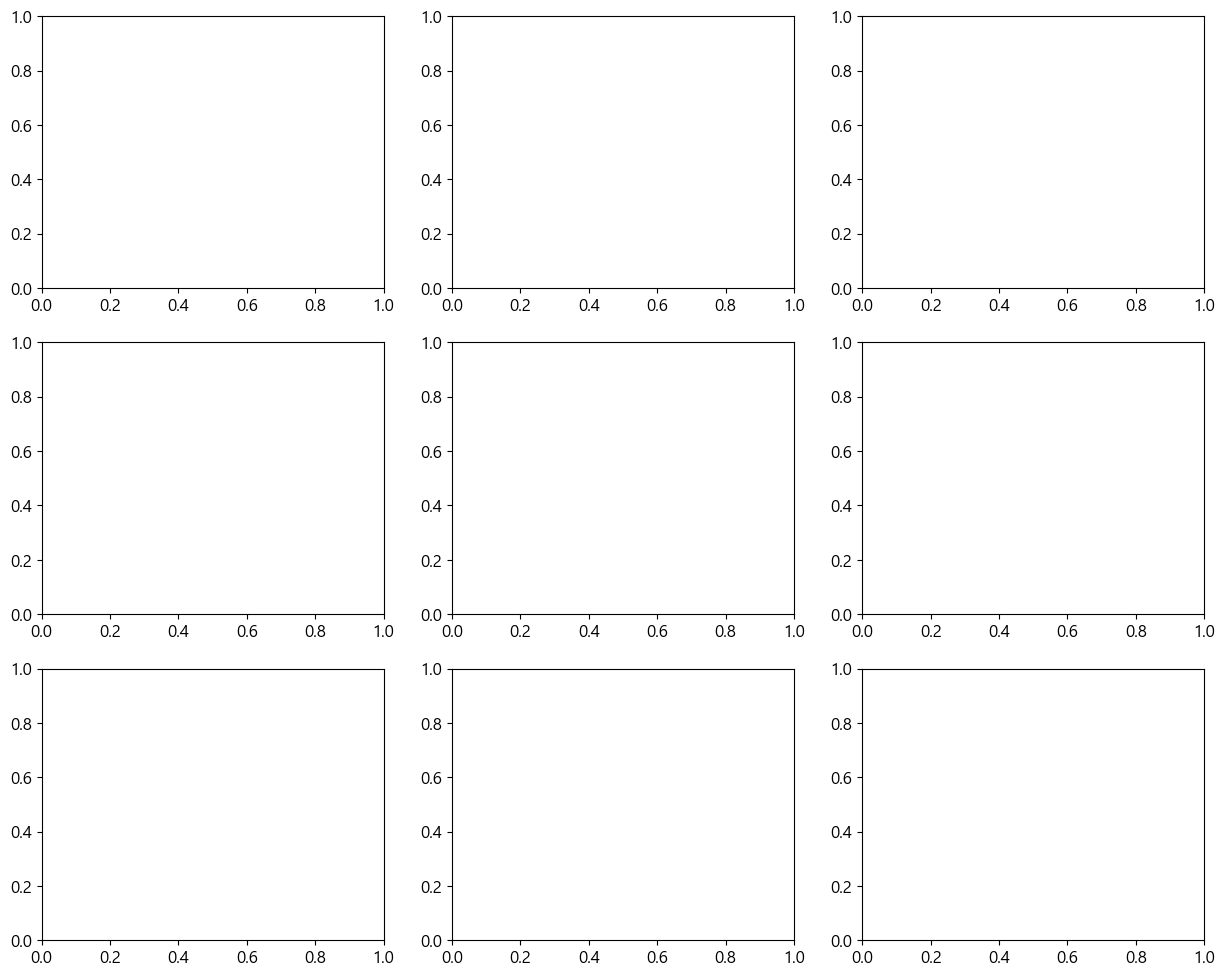

In [ ]:
# 모든 실험에 대한 예측 수행

# 전체 데이터셋 크기 확인
num_experiments = len(train_dataset)
print(f"총 {num_experiments}개의 실험 데이터가 있습니다.")

# 모든 실험에 대한 예측 수행
model.eval()
all_predictions = []
all_actuals = []
all_seq_lengths = []

print("모든 실험에 대한 예측을 수행 중...")

with torch.no_grad():
    for exp_idx in range(num_experiments):
        # 각 실험의 데이터 준비
        test_init = train_dataset.init[exp_idx:exp_idx+1]
        test_states = train_dataset.states[exp_idx:exp_idx+1]
        test_CV = train_dataset.CV[exp_idx:exp_idx+1]
        test_seq_len = train_dataset.seq_lengths[exp_idx]
        
        # GPU로 이동
        init = test_init.to(device)
        CV = test_CV.to(device)
        seq_length = test_seq_len.item()
        
        # 예측 수행
        pred_states = model(CV, init, states=None, masks=None, 
                           max_steps=seq_length, mode='inference')
        
        # 결과 저장
        actual_states = test_states[0].cpu().numpy()
        if len(pred_states.shape) == 3:
            pred_states_np = pred_states[0].cpu().numpy()
        else:
            pred_states_np = pred_states.cpu().numpy()
        
        all_predictions.append(pred_states_np)
        all_actuals.append(actual_states)
        all_seq_lengths.append(seq_length)
        
        print(f"실험 {exp_idx} 완료 (시퀀스 길이: {seq_length})")

print("모든 예측 완료!")

# 상태 변수 정보
state_names = ['CFLA', 'CALA', 'CFK', 'CBK', 'VF', 'VA', 'VB']
state_indices = [0, 1, 2, 3, 4, 5, 6]

# 각 실험별로 모든 상태 변수를 한 번에 시각화
for exp_idx in range(num_experiments):
    # 3x3 서브플롯 생성 (7개 변수용)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    seq_length = all_seq_lengths[exp_idx]
    
    # 각 상태 변수별 플롯
    for state_idx, state_name in enumerate(state_names):
        ax = axes[state_idx]
        
        # 해당 실험의 데이터
        actual_data = all_actuals[exp_idx][:seq_length, state_idx]
        pred_data = all_predictions[exp_idx][:seq_length, state_idx]
        time_steps = range(seq_length)
        
        # 플롯
        ax.plot(time_steps, actual_data, 'o-', label='Actual', alpha=0.8,
                markersize=5, linewidth=2, color='blue')
        ax.plot(time_steps, pred_data, 's--', label='Predicted', alpha=0.8,
                markersize=4, linewidth=2, color='red')
        
        ax.set_title(f'{state_name}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time step', fontsize=10)
        ax.set_ylabel('Normalized value', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.1, 1.1)
        
        # R² 계산 및 표시
        r2 = r2_score(actual_data, pred_data)
        ax.text(0.02, 0.98, f'R² = {r2:.4f}', transform=ax.transAxes,
                verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # 빈 서브플롯 제거
    for i in range(len(state_names), len(axes)):
        axes[i].remove()
    
    plt.tight_layout()
    plt.suptitle(f'Experiment {exp_idx} - All State Variables (Sequence Length: {seq_length})', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# 전체 정량적 평가 결과 (R² 기준)
print("\n" + "="*80)
print("전체 실험에 대한 R² 평가 결과")
print("="*80)

# 각 상태 변수별 전체 R² 계산
overall_results = []

for state_idx, state_name in enumerate(state_names):
    all_r2 = []
    
    for exp_idx in range(num_experiments):
        actual_data = all_actuals[exp_idx][:all_seq_lengths[exp_idx], state_idx]
        pred_data = all_predictions[exp_idx][:all_seq_lengths[exp_idx], state_idx]
        
        r2 = r2_score(actual_data, pred_data)
        all_r2.append(r2)
    
    # 통계 계산
    mean_r2 = np.mean(all_r2)
    std_r2 = np.std(all_r2)
    min_r2 = np.min(all_r2)
    max_r2 = np.max(all_r2)
    
    overall_results.append({
        'name': state_name,
        'r2_mean': mean_r2,
        'r2_std': std_r2,
        'r2_min': min_r2,
        'r2_max': max_r2,
        'all_r2': all_r2
    })
    
    print(f"{state_name:4s}: R² = {mean_r2:.4f}±{std_r2:.4f} "
          f"(min: {min_r2:.4f}, max: {max_r2:.4f})")

print("-"*80)

# 전체 평균 R²
total_r2_mean = np.mean([r['r2_mean'] for r in overall_results])
print(f"전체 평균 R²: {total_r2_mean:.4f}")
print("="*80)

# 실험별 성능 요약 (전체 상태 변수 평균 R²)
print("\n실험별 R² 성능 요약")
print("-"*50)
exp_r2_summary = []

for exp_idx in range(num_experiments):
    exp_r2 = []
    
    for state_idx in range(len(state_names)):
        actual_data = all_actuals[exp_idx][:all_seq_lengths[exp_idx], state_idx]
        pred_data = all_predictions[exp_idx][:all_seq_lengths[exp_idx], state_idx]
        
        r2 = r2_score(actual_data, pred_data)
        exp_r2.append(r2)
    
    mean_exp_r2 = np.mean(exp_r2)
    exp_r2_summary.append(mean_exp_r2)
    
    print(f"실험 {exp_idx}: 평균 R² = {mean_exp_r2:.4f}, 시퀀스 길이 = {all_seq_lengths[exp_idx]}")

# 상태 변수별 R² 히트맵 (선택사항)
print("\n상태 변수별 × 실험별 R² 매트릭스:")
print("-"*50)
print("실험\\변수", end="")
for state_name in state_names:
    print(f"{state_name:>8s}", end="")
print()

for exp_idx in range(num_experiments):
    print(f"실험 {exp_idx:2d}", end="")
    for state_idx in range(len(state_names)):
        actual_data = all_actuals[exp_idx][:all_seq_lengths[exp_idx], state_idx]
        pred_data = all_predictions[exp_idx][:all_seq_lengths[exp_idx], state_idx]
        r2 = r2_score(actual_data, pred_data)
        print(f"{r2:8.4f}", end="")
    print()

print("\n모든 실험에 대한 분석 완료!")
print(f"총 {num_experiments}개 실험, {len(state_names)}개 상태 변수에 대한 R² 분석이 완료되었습니다.")